# 回声检测大作业

## 原理

$y(t) = x(t) + \alpha x(t - T)$

$$
\begin{aligned}
y(0) &= x(0) \\
y(1) &= x(1) \\
&\vdots \\
y(T) &= x(T) + \alpha x(0) \\
y(T + 1) &= x(T) + \alpha x(1) \\
&\vdots \\
y(n) &= x(n) + \alpha x(n - T) \\
\end{aligned}
$$

所以

$\left(E_{n+1} + \begin{pmatrix} 0 & 0 \\ \alpha E_{n-T+1} & 0 \end{pmatrix}\right) \cdot \boldsymbol x = \boldsymbol y$

所以

$\boldsymbol x = \left(E_{n+1} + \begin{pmatrix} 0 & 0 \\ \alpha E_{n-T+1} & 0 \end{pmatrix}\right)^{-1} \cdot \boldsymbol y$

当 $x(t) = \delta (t),\, y(t) = \delta (t) + \alpha \delta (t-T)$ 为冲激响应。

## 载入数据

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mat = loadmat('lab1.mat')

def aec_1(signal, alpha, T):
    signal = np.array(signal)
    n = len(signal)
    E = np.identity(n, dtype=float)
    for i in range(n-T, n):
        E[i][i] = alpha
    return np.linalg.inv(E) @ signal

def aec_2(signal, alpha_1, T_1, alpha_2, T_2):
    signal = np.array(signal)
    n = len(signal)
    E = np.identity(n, dtype=float)
    for i in range(n-T_1, n):
        E[i][i] = alpha_1
    for i in range(n-T_2, n):
        E[i][i] = alpha_2
    return np.linalg.inv(E) @ signal

## 对Q2回声的消除

$T = 1000,\,\alpha = 0.5$

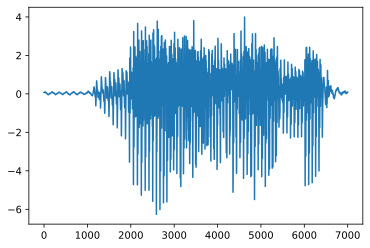

In [2]:
T_2 = 1000
alpha_2 = 0.5
plt.plot(aec_1(mat['Q2'],alpha_2, T_2))
plt.show()

## 对Q3回声的消除

$T = \arg\max\left(R_{yy}[n]\right) = \displaystyle{\arg\max\left(\sum_{m=\infty}^{\infty}(y[m+n]y[m])\right) \quad (T \not = 0)}$

因为第一个峰值出现在$t=0$附近，第二个峰值对应的时刻即为$T$.两峰值之比即为$\alpha \quad(\alpha \in [0,\,1])$

In [3]:
def cal_Rxx_1(signal):
    signal = signal.flatten()
    R_xx = np.correlate(signal,signal,mode='full')
    R_xx = R_xx[int(len(R_xx)/2):len(R_xx)]
    plt.plot(R_xx)
    plt.title(r"$R_{xx}$")
    plt.show()
    result = R_xx.argpartition(-2)
    max_item = R_xx.argmax()
    for i in range(len(result)-1,0,-1):
        if result[i] < max_item + 100 and result[i] > max_item - 100:
            continue
        else:
            alpha = (R_xx[result[i]]/R_xx[max_item])
            return (result[i], alpha)


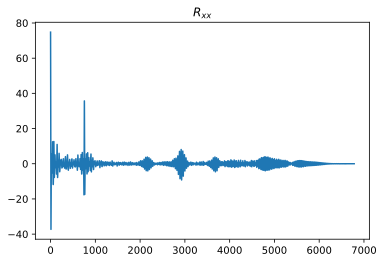

T = 755, alpha = 0.477


In [4]:
T_3, alpha_3 = cal_Rxx_1(mat['Q3'])
print("T = %d, alpha = %.3f"%(T_3, alpha_3))

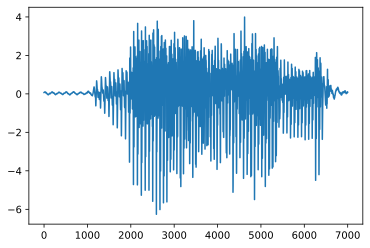

In [5]:
plt.plot(aec_1(mat['Q2'],alpha_3, T_3))
plt.show()

## 对Q4回声的消除

### 利用互相关函数求解

$Q_4$与$Q_3$的原声信号的互相关函数会在$t=0$、$t=T_1$和$t=T_2$时取到峰值，故可以用互相关函数估计$T_1$和$T_2$。同时，两峰值与$0$处值之比也分别为$\alpha_1$ 和 $\alpha_2$

In [6]:
origin = aec_1(mat['Q3'],alpha_3 ,T_3)

In [7]:
def cal_Rxy_1(signal_1, signal_2):
    signal_1 = signal_1.flatten()
    signal_2 = signal_2.flatten()
    R_xy = np.correlate(signal_1,signal_2,mode='full')
    R_xy = R_xy[int(len(R_xy)/2):len(R_xy)]
    plt.plot(R_xy)
    plt.title(r"$R_{xy}$")
    plt.show()
    result = R_xy.argpartition(-2)
    max_item = R_xy.argmax()
    temp = 0
    for i in range(len(result)-1,0,-1):
        if result[i] < max_item + 100 and result[i] > max_item - 100:
            continue
        else:
            temp = result[i]
            break
    for j in range(len(result)-1,0,-1):
        if (result[j] < max_item + 100 and result[j] > max_item -100) or (
            result[j] < temp + 100 and result[j] > temp - 100):
            continue
        else:
            return (max_item, R_xy[result[j]]/R_xy[max_item] ,temp, R_xy[result[j]]/R_xy[temp])

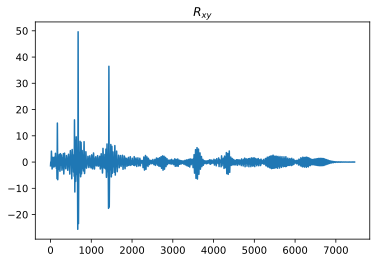

T1 = 677, alpha1 = 0.223, T2 = 1429, alpha2 = 0.624


In [8]:
T_41, alpha_41, T_42, alpha_42 = cal_Rxy_1(origin, mat['Q4'])
print("T1 = %d, alpha1 = %.3f, T2 = %d, alpha2 = %.3f"%(T_41, alpha_41, T_42, alpha_42))

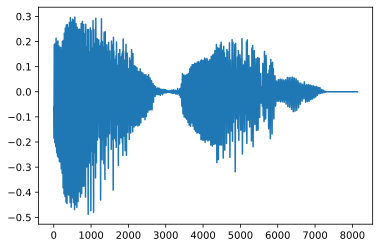

In [9]:
plt.plot(aec_2(mat['Q4'], alpha_41, T_41, alpha_42, T_42))
plt.show()

### 利用自相关函数求解

在不提供原声信号的条件下，$Q_4$的自相关函数会在$t=0$、$t=T_1$和$t=T_2$时取到峰值，故可以用自相关函数估计$T_1$和$T_2$。

In [10]:
def cal_Rxx_2(signal_1):
    signal = signal_1.flatten()
    R_xx = np.correlate(signal,signal,mode='full')
    R_xx = R_xx[int(len(R_xx)/2):len(R_xx)]
    plt.plot(R_xx)
    plt.title(r"$R_{xx}$")
    plt.show()
    result = R_xx.argpartition(-2)
    max_item = R_xx.argmax()
    count = 0
    temp = 0
    for i in range(len(result)-1,0,-1):
        if (result[i] < max_item + 100 and result[i] > max_item - 100) or (
            result[i] < temp + 100 and result[i] > temp - 100):
            continue
        else:
            if count == 2:
                return (temp, R_xx[temp]/R_xx[max_item], result[i], R_xx[result[i]]/R_xx[max_item])
            else:
                temp = result[i]
                count+=1

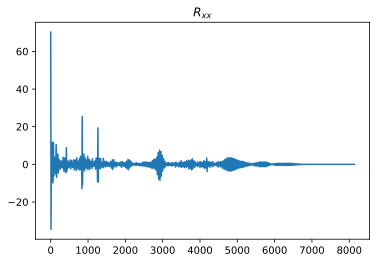

T1 = 843, alpha1 = 0.332, T2 = 1262, alpha2 = 0.198


In [11]:
T_51, alpha_51, T_52, alpha_52 = cal_Rxx_2(mat['Q4'])
print("T1 = %d, alpha1 = %.3f, T2 = %d, alpha2 = %.3f"%(T_51, alpha_51, T_52, alpha_52))

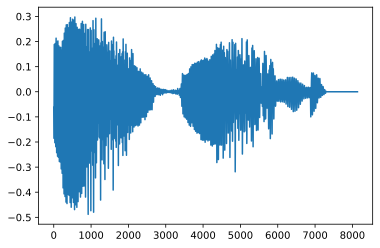

In [12]:
plt.plot(aec_2(mat['Q4'], alpha_51, T_51, alpha_52, T_52))
plt.show()

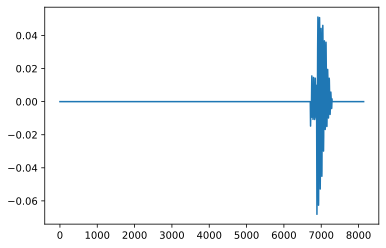

In [13]:
plt.plot(aec_2(mat['Q4'], alpha_51, T_51, alpha_52, T_52) - aec_2(mat['Q4'], alpha_41, T_41, alpha_42, T_42))
plt.show()

从图中可以看出，尽管两种方法对于$T_1$和$T_2$以及$\alpha_1$和$\alpha_2$的估计值有较大差异，但两种方法得到的原声信号差异并不大，所以两种方法均可以实现对于回声信号的消除。